In [1]:
!pip install tokenizers --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.9 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 32.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 4.3 MB/s eta 0:00:000:00:0100:01


In [35]:
from nltk.corpus import reuters, inaugural
from nltk.tokenize import word_tokenize
from collections import Counter
from tqdm import tqdm
import numpy as np
import nltk
import random

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
# import torchtext

from tokenizers import Tokenizer
from tokenizers.models import WordLevel, BPE
from tokenizers.trainers import WordLevelTrainer, BpeTrainer
from tokenizers.pre_tokenizers import Whitespace

import matplotlib.pyplot as plt

import time

import math

random.seed(42)

In [3]:
# Download necessary NLTK resources
nltk.download('reuters')
nltk.download('inaugural')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package reuters to /usr/share/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package inaugural to /usr/share/nltk_data...
[nltk_data]   Package inaugural is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [4]:
# Load the Reuters dataset
categories = reuters.categories()
documents = reuters.fileids()
random.shuffle(documents) # randomly shuffle the documents
print(f"Number of documents: {len(documents)}")

Number of documents: 10788


In [5]:
n_total = len(documents)
n_train = int(0.8 * n_total)
n_val   = int(0.1 * n_total)
n_test  = n_total - n_train - n_val

In [6]:
train_ids = documents[:n_train]
val_ids = documents[n_train:n_train + n_val]
test_ids = documents[n_train + n_val:]

In [7]:
# tokenize and lowercase the characters
train_data = [reuters.raw(fid).lower() for fid in train_ids]
val_data = [reuters.raw(fid).lower() for fid in val_ids]
test_data = [reuters.raw(fid).lower() for fid in test_ids]

In [8]:
def create_tokenizer_trainer(byte_pair: bool, vocab_size):
    if byte_pair:
        tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
        tokenizer.pre_tokenizer = Whitespace()
        trainer = BpeTrainer(
            special_tokens=["[UNK]", "[PAD]", "[BOS]", "[EOS]"],
            vocab_size=vocab_size
        )
    else:
        tokenizer = Tokenizer(WordLevel(unk_token='[UNK]'))
        tokenizer.pre_tokenizer = Whitespace()
        trainer = WordLevelTrainer(
            special_tokens=["[UNK]", "[PAD]", "[BOS]", "[EOS]"],
            vocab_size=vocab_size
        )
    return tokenizer, trainer

In [9]:
tokenizer, trainer = create_tokenizer_trainer(byte_pair=False, vocab_size=10000)
tokenizer.train_from_iterator(train_data, trainer)

In [111]:
def encode_text(ids: list[str], tokenizer):
    # process the data
    processed = []
    start_token_id = tokenizer.token_to_id("[BOS]")
    end_token_id = tokenizer.token_to_id("[EOS]")
    for fid in ids:
        raw_text = reuters.raw(fid)
        ids = tokenizer.encode(raw_text).ids
        processed.append([start_token_id] + ids + [end_token_id])
    return processed

In [11]:
train_processed = encode_text(train_ids, tokenizer)
val_processed = encode_text(val_ids, tokenizer)
test_processed = encode_text(test_ids, tokenizer)

In [13]:
class ReutersDataset(Dataset):
    def __init__(self, texts, seq_len=30):
        self.seq_len = seq_len
        self.data = []
        
        for text in texts:
            if len(text) > seq_len:
                # slide window
                for i in range(len(text) - seq_len):
                    seq = text[i:i+seq_len+1]  # need +1 for target
                    self.data.append(seq)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        seq = torch.tensor(self.data[idx], dtype=torch.long)
        # input = first seq_len tokens
        x = seq[:-1]
        # target = same sequence shifted by one
        y = seq[1:]
        return x, y

In [14]:
train_dataset = ReutersDataset(train_processed)
val_dataset = ReutersDataset(val_processed)
test_dataset = ReutersDataset(test_processed)

In [15]:
train_dataloader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1024, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1024, shuffle=True)

In [16]:
class LSTMLanguageModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, dropout_p):
        super().__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, dropout=dropout_p)
        self.fc = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, x, hidden=None):
        batch_size = x.size(0)
        
        # initialize hidden state if not provided
        if hidden is None:
            h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=x.device)
            c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=x.device)
            hidden = (h0, c0)
        
        x = self.embedding(x)
        out, hidden = self.lstm(x, hidden)
        out = self.fc(out)
        
        return out, hidden

## Train model 1

embed_size = 128
hidden_size = 128
num_layers = 2
dropout_p = 0.1

In [22]:
torch.manual_seed(42)
model = LSTMLanguageModel(
    vocab_size=tokenizer.get_vocab_size(),
    embed_size=128,
    hidden_size=128,
    num_layers=2,
    dropout_p=0.1
)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)
vocab_size = tokenizer.get_vocab_size()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

LSTMLanguageModel(
  (embedding): Embedding(10000, 128)
  (lstm): LSTM(128, 128, num_layers=2, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=128, out_features=10000, bias=True)
)

In [23]:
def train(model, loss_fn, optimizer, dataloader, device, vocab_size):
    model.train()
    total_loss = 0
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs, hidden = model(inputs)  # [batch, seq_len, vocab_size]

        # reshape for CrossEntropyLoss
        loss = loss_fn(outputs.view(-1, vocab_size), targets.view(-1))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


def evaluate(model, loss_fn, dataloader, device, vocab_size):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs, hidden = model(inputs)
            loss = loss_fn(outputs.view(-1, vocab_size), targets.view(-1))
            total_loss += loss.item()

    return total_loss / len(dataloader)

In [24]:
best_val_loss = float('inf')
train_losses = []
val_losses = []
NUM_EPOCHS = 10

start_time = time.time()

for epoch in range(NUM_EPOCHS):
    train_loss = train(model, criterion, optimizer, train_dataloader, device, vocab_size)
    val_loss = evaluate(model, criterion, val_dataloader, device, vocab_size)

    # save model with best validation loss each time
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "lstm_best.pt")

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch: {epoch + 1}.")
    print(f"Train loss = {train_loss:.4f}, Validation loss = {val_loss:.4f}")
    print(f"Train perplexity = {math.exp(train_loss): .4f}, Validation perplexity = {math.exp(val_loss): .4f}")
    print("*" * 100)

end_time = time.time()

print(f"Training took {end_time - start_time: .2f} seconds")

Epoch: 1.
Train loss = 4.0890, Validation loss = 3.7691
Train perplexity =  59.6791, Validation perplexity =  43.3415
****************************************************************************************************
Epoch: 2.
Train loss = 3.3793, Validation loss = 3.6388
Train perplexity =  29.3490, Validation perplexity =  38.0449
****************************************************************************************************
Epoch: 3.
Train loss = 3.1181, Validation loss = 3.6395
Train perplexity =  22.6035, Validation perplexity =  38.0726
****************************************************************************************************
Epoch: 4.
Train loss = 2.9840, Validation loss = 3.6682
Train perplexity =  19.7676, Validation perplexity =  39.1798
****************************************************************************************************
Epoch: 5.
Train loss = 2.9045, Validation loss = 3.7010
Train perplexity =  18.2561, Validation perplexity =  40.4895
******

### Plot training and validation loss curves

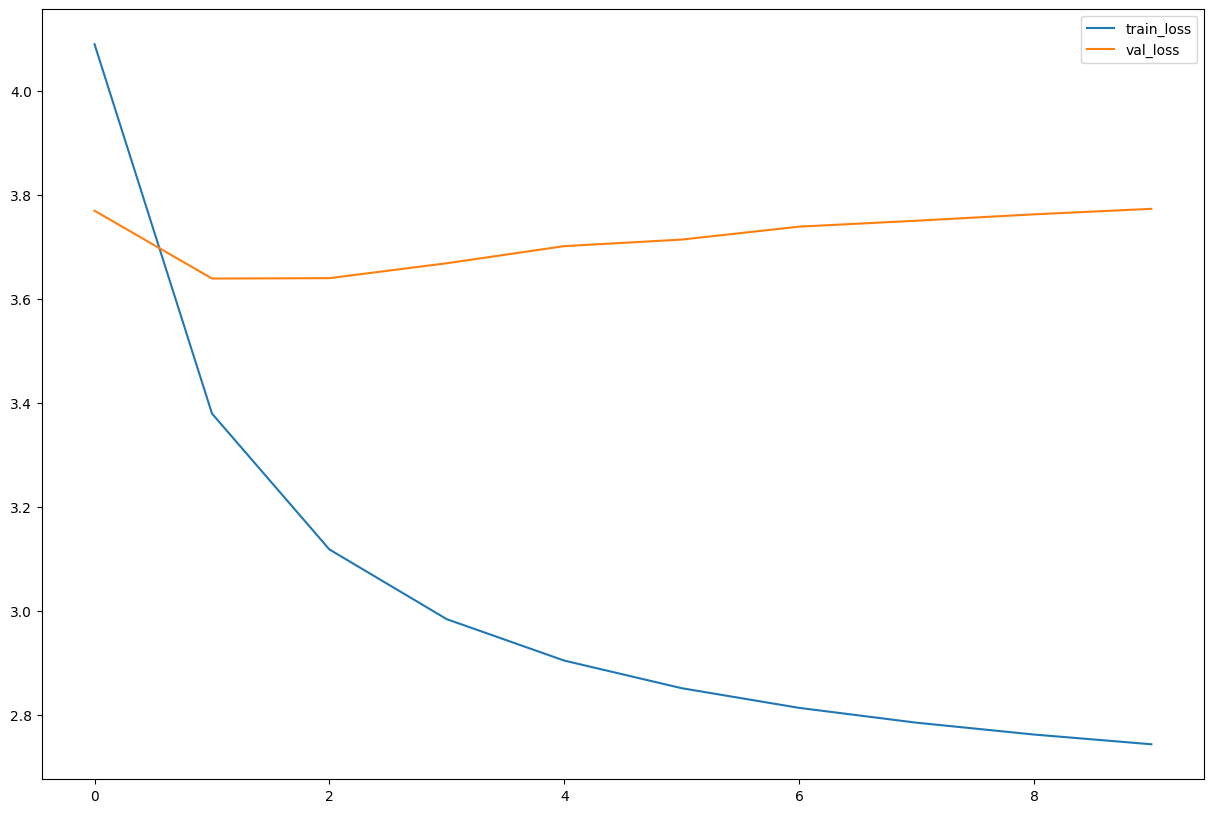

In [25]:
plt.figure(figsize=(15, 10))
plt.plot(train_losses, label='train_loss')
plt.plot(val_losses,label='val_loss')
plt.legend()
plt.show()

Model overfitted on the training data

### Evaluate on test set

In [26]:
# load best model so far
model.load_state_dict(
    torch.load('/kaggle/working/lstm_best.pt', map_location='cuda')
)

<All keys matched successfully>

In [73]:
test_loss = evaluate(model, criterion, test_dataloader, device, vocab_size)
print(f"Test loss = {test_loss:.4f}")
print(f"Test perplexity = {math.exp(test_loss): .4f}")

Test loss = 3.6995
Test perplexity =  40.4271


### Sample text generation

In [59]:
def generate_text(model, tokenizer, start_text, max_new_tokens=200, temperature=1.0, device="cuda"):
    model.eval()
    model.to(device)

    # Encode start text into token IDs
    input_ids = tokenizer.encode(start_text).ids
    start_token_id = tokenizer.token_to_id("[BOS]")
    input_ids = torch.tensor([[start_token_id] + input_ids], dtype=torch.long).to(device)

    hidden = None
    generated_ids = input_ids[0].tolist()

    with torch.no_grad():
        for _ in range(max_new_tokens):
            # Forward pass
            logits, hidden = model(input_ids, hidden)

            # Take last token's logits
            logits = logits[:, -1, :]  # shape [batch, vocab_size]

            # Apply temperature
            probs = F.softmax(logits / temperature, dim=-1)

            # Sample next token
            next_id = torch.multinomial(probs, num_samples=1).item()

            # Append
            generated_ids.append(next_id)

            if next_id == tokenizer.token_to_id("[EOS]"):
                break

            # Prepare next input
            input_ids = torch.tensor([[next_id]], dtype=torch.long).to(device)

    # Decode back to text
    return tokenizer.decode(generated_ids, skip_special_tokens=True)

In [94]:
start = "in 1987"
text = generate_text(model, tokenizer, start, max_new_tokens=200, temperature=1.0, device="cuda")

In [95]:
text

"in 1987 / 88 in is expected to rise by 565 billion markka in the day . said the way is set for stockpile projects . said that the government had no intention of up to 482 . 0 mln dlrs from 1986 last fall was effected in 1987 . said the results came after a 15 . 5 billion shilling rise a longer term treasury bills to non - to and at 34 . 50 dlrs per mcf to 49 . 80 pct compared with 953 mln dlrs , the 4 . 56 billion dlrs for year on 1 . bank did not revise up costs to date into account for new funds from the group ' s stock split and a minimum time public distribution of 6 . 0 mln - 6 . 4 mln dlrs or 1 . 46 dlrs from 32 . 25 dlrs a share . month , either managing franchise operations said . said reduced cuts and 38 business benefits of using all of the key issues had change . said if a bill is a 1 . 5 pct"

In [100]:
start = "united states"
text = generate_text(model, tokenizer, start, max_new_tokens=200, temperature=1.0, device="cuda")

In [101]:
text

"united states . branch has made clear that the company ' s bad results would only lead out of reserves and inflation and holding - boat loans after rapid steep fall and that existed for energy reserves and some management program and the other third of the area , is debtors in 1978 of foreign machinery products , including commercial oils , traders said . the agreement , it said . will meet with non - bank currency , which was to be firmer by the plant was remained around 25 pct after the next extreme monthly contract between petroleum and electricity mostly back to 9 . 8 billion dlrs from 4 . 99 billion dlrs in in 1986 , after rising 106 . 37 billion in , the sharp drop in non - intervention , which stood at 10 . 45 billion shares in the managing consecutive four straight large loans for vegetable oil and feed complex is set at around 92 , 280 , 000 tonnes , a lack of regulations , momentum , notably and exports during the second half for 1986 , the paper said a deficit of"

## Train model 2

embed_size = 128
hidden_size = 128
num_layers = 2
dropout_p = 0.3

In [ ]:
# use higher dropout rate to prevent overfitting

In [71]:
torch.manual_seed(42)
model_2 = LSTMLanguageModel(
    vocab_size=tokenizer.get_vocab_size(),
    embed_size=128,
    hidden_size=128,
    num_layers=2,
    dropout_p=0.3
)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_2.parameters(), lr=0.01)
vocab_size = tokenizer.get_vocab_size()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_2.to(device)

LSTMLanguageModel(
  (embedding): Embedding(10000, 128)
  (lstm): LSTM(128, 128, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=128, out_features=10000, bias=True)
)

In [72]:
best_val_loss = float('inf')
train_losses = []
val_losses = []
NUM_EPOCHS = 10

start_time = time.time()

for epoch in range(NUM_EPOCHS):
    train_loss = train(model_2, criterion, optimizer, train_dataloader, device, vocab_size)
    val_loss = evaluate(model_2, criterion, val_dataloader, device, vocab_size)

    # save model with best validation loss each time
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_2.state_dict(), "lstm_best_2.pt")

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch: {epoch + 1}.")
    print(f"Train loss = {train_loss:.4f}, Validation loss = {val_loss:.4f}")
    print(f"Train perplexity = {math.exp(train_loss): .4f}, Validation perplexity = {math.exp(val_loss): .4f}")
    print("*" * 100)

end_time = time.time()

print(f"Training took {end_time - start_time: .2f} seconds")

Epoch: 1.
Train loss = 4.1692, Validation loss = 3.7613
Train perplexity =  64.6607, Validation perplexity =  43.0050
****************************************************************************************************
Epoch: 2.
Train loss = 3.4822, Validation loss = 3.6044
Train perplexity =  32.5305, Validation perplexity =  36.7605
****************************************************************************************************
Epoch: 3.
Train loss = 3.2532, Validation loss = 3.5805
Train perplexity =  25.8726, Validation perplexity =  35.8921
****************************************************************************************************
Epoch: 4.
Train loss = 3.1384, Validation loss = 3.5882
Train perplexity =  23.0674, Validation perplexity =  36.1681
****************************************************************************************************
Epoch: 5.
Train loss = 3.0705, Validation loss = 3.6003
Train perplexity =  21.5520, Validation perplexity =  36.6099
******

### Plot training and validation loss curves

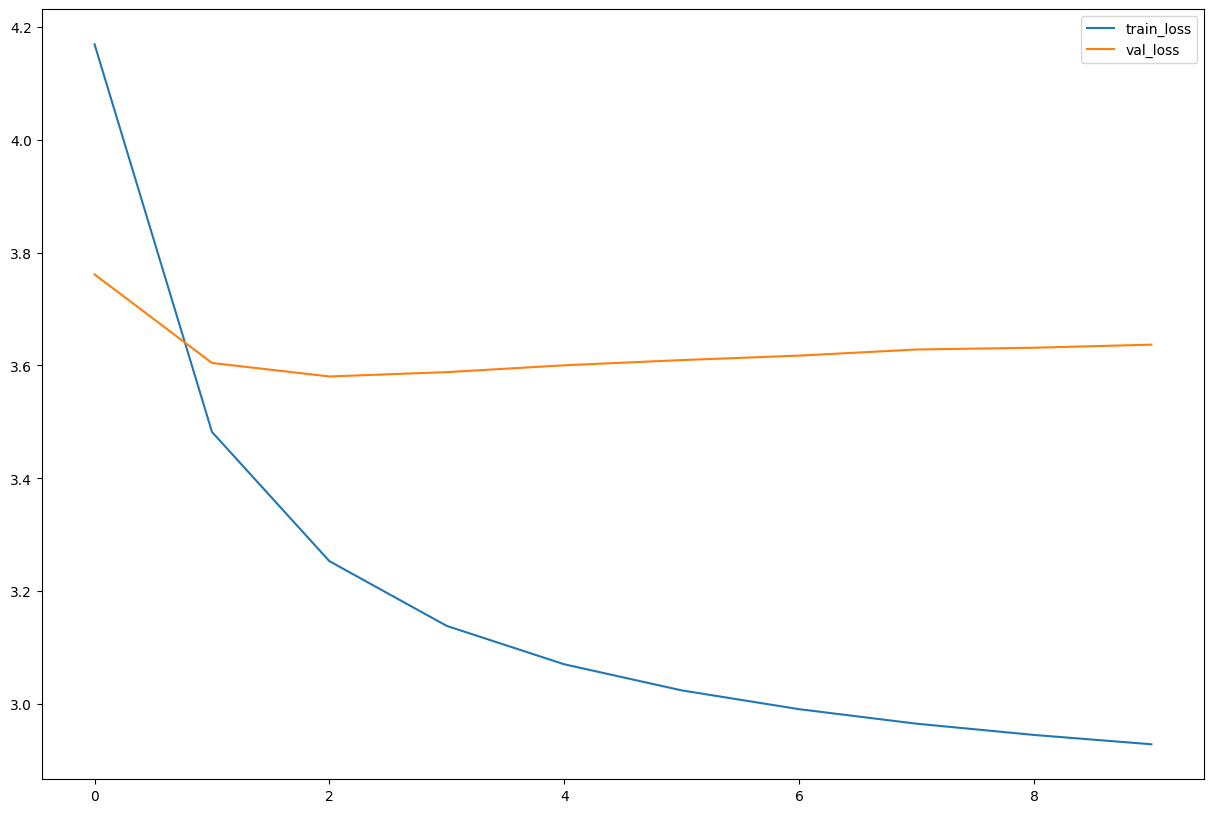

In [77]:
plt.figure(figsize=(15, 10))
plt.plot(train_losses, label='train_loss')
plt.plot(val_losses,label='val_loss')
plt.legend()
plt.show()

### Evaluate on test set

In [75]:
model_2.load_state_dict(
    torch.load('/kaggle/working/lstm_best_2.pt', map_location='cuda')
)

<All keys matched successfully>

In [76]:
test_loss = evaluate(model_2, criterion, test_dataloader, device, vocab_size)
print(f"Test loss = {test_loss:.4f}")
print(f"Test perplexity = {math.exp(test_loss): .4f}")

Test loss = 3.6457
Test perplexity =  38.3114


### Sample text generation

In [106]:
start = "in 1987"
text = generate_text(model_2, tokenizer, start, max_new_tokens=200, temperature=1.0, device="cuda")

In [107]:
text

'in 1987 / 88 nuclear summit has pledged to cut demand for the large components , which are subject to statements to continued support for last \' s sharp rise in the tin economy as \' s performance in the second half of 1987 export levels . estimated the field \' s 538 mln dlr reported to its three major firms performed over the present grains area while the international market market share were expected to be . " have not established efforts to stabilise a problem that might easily protect the company ," said . " \' s not reacting to central bank thought that there were an immediate change between two times ," said . " we are not going to now break beyond at about 100 . 50 marks or any change in an government the yen amount of a means that gross national product growth ," told the said he was extremely important , up strongly the highly difficult . analysts will also say the conflict used , however , the internal tech and industry will be to assure the makers to push'

In [84]:
start = "united states"
text = generate_text(model_2, tokenizer, start, max_new_tokens=200, temperature=1.0, device="cuda")

In [85]:
text

'united states to slash production at an estimated 52 pct by es 1986 . the daily revenue of , said it forecast the shortage of 15 . 8 to 34 . 0 pct to 270 tons behind the half - half point in . demand had fallen 6 . 70 pct from 4 . 825 pct in 1986 , money center statistics show seven to four pct net profits in the second half of 1986 compared with forecast last year when figures to the bank sales contributed to its latest year . heavy weather were well stocked with treasury operations in 1986 , partly maturing in the gross national debt . " private sector growth is likely to grow , due mainly to further growth adjustments by the future money market liquidity at 15 . 9 billion dollars ( ) a short - term costs and cutting in which benefit cuts had stocks . said he supported were . were not immediately available for service exports . banks were now worried about the picture among a rate shift by a major'

## Train model 3

embed_size = 128
hidden_size = 128
num_layers = 2
dropout_p = 0.1

Using subword tokenization (BPE) instead

In [112]:
tokenizer, trainer = create_tokenizer_trainer(byte_pair=True, vocab_size=10000)
tokenizer.train_from_iterator(train_data, trainer)

In [113]:
train_processed = encode_text(train_ids, tokenizer)
val_processed = encode_text(val_ids, tokenizer)
test_processed = encode_text(test_ids, tokenizer)

In [114]:
train_dataset = ReutersDataset(train_processed)
val_dataset = ReutersDataset(val_processed)
test_dataset = ReutersDataset(test_processed)

train_dataloader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1024, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1024, shuffle=True)

In [115]:
torch.manual_seed(42)
model_3 = LSTMLanguageModel(
    vocab_size=tokenizer.get_vocab_size(),
    embed_size=128,
    hidden_size=128,
    num_layers=2,
    dropout_p=0.1
)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_3.parameters(), lr=0.01)
vocab_size = tokenizer.get_vocab_size()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_3.to(device)

LSTMLanguageModel(
  (embedding): Embedding(10000, 128)
  (lstm): LSTM(128, 128, num_layers=2, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=128, out_features=10000, bias=True)
)

In [116]:
best_val_loss = float('inf')
train_losses = []
val_losses = []
NUM_EPOCHS = 10

start_time = time.time()

for epoch in range(NUM_EPOCHS):
    train_loss = train(model_3, criterion, optimizer, train_dataloader, device, vocab_size)
    val_loss = evaluate(model_3, criterion, val_dataloader, device, vocab_size)

    # save model with best validation loss each time
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_3.state_dict(), "lstm_best_3.pt")

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch: {epoch + 1}.")
    print(f"Train loss = {train_loss:.4f}, Validation loss = {val_loss:.4f}")
    print(f"Train perplexity = {math.exp(train_loss): .4f}, Validation perplexity = {math.exp(val_loss): .4f}")
    print("*" * 100)

end_time = time.time()

print(f"Training took {end_time - start_time: .2f} seconds")

Epoch: 1.
Train loss = 3.5641, Validation loss = 3.3105
Train perplexity =  35.3084, Validation perplexity =  27.3975
****************************************************************************************************
Epoch: 2.
Train loss = 2.9145, Validation loss = 3.2419
Train perplexity =  18.4401, Validation perplexity =  25.5818
****************************************************************************************************
Epoch: 3.
Train loss = 2.7343, Validation loss = 3.2539
Train perplexity =  15.3987, Validation perplexity =  25.8900
****************************************************************************************************
Epoch: 4.
Train loss = 2.6459, Validation loss = 3.2664
Train perplexity =  14.0964, Validation perplexity =  26.2160
****************************************************************************************************
Epoch: 5.
Train loss = 2.5927, Validation loss = 3.2808
Train perplexity =  13.3653, Validation perplexity =  26.5966
******

### Plot training and validation loss curves

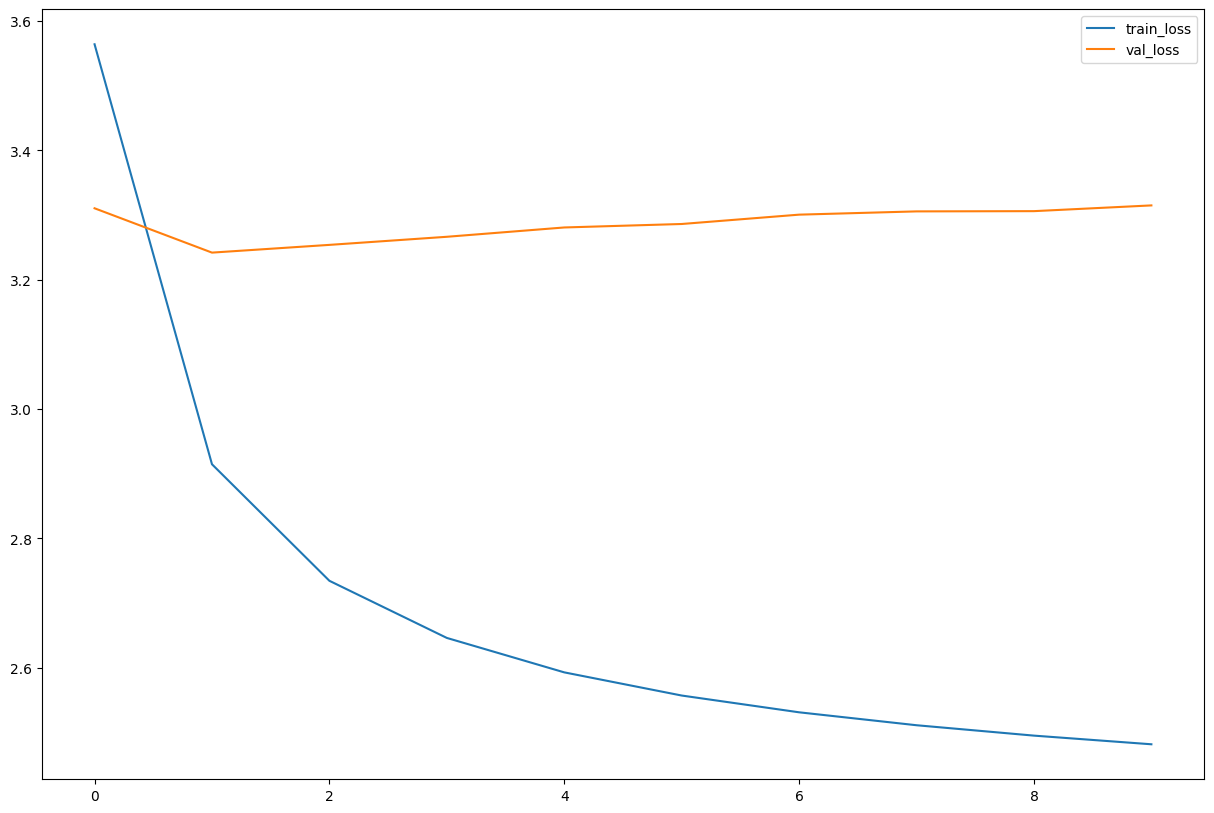

In [117]:
plt.figure(figsize=(15, 10))
plt.plot(train_losses, label='train_loss')
plt.plot(val_losses,label='val_loss')
plt.legend()
plt.show()

### Evaluate against test data

In [118]:
model_3.load_state_dict(
    torch.load('/kaggle/working/lstm_best_3.pt', map_location='cuda')
)

<All keys matched successfully>

In [119]:
test_loss = evaluate(model_3, criterion, test_dataloader, device, vocab_size)
print(f"Test loss = {test_loss:.4f}")
print(f"Test perplexity = {math.exp(test_loss): .4f}")

Test loss = 3.3018
Test perplexity =  27.1619


### Sample text generation

In [120]:
start = "in 1987"
text = generate_text(model_3, tokenizer, start, max_new_tokens=200, temperature=1.0, device="cuda")

In [121]:
text

'in 1987 deposits after up 38 . 5 pct from ply 30 mln dlrs from 10 . 25 mln barrels in 1986 because the current account low of around 813 , 000 tonnes of gasoline from the . . t output in the corresponding fiscal year . nd er many fields representing up to 101 mln stg in band one from the ac ific t for the week after the expected demand ," said ner gy o , said . red it or por ate and international prices exchange for the half - bonus gain in four mths , of its pipeline acreage allow ances it \' s equity certificate of living index , r it ain . m per ial statistics covered to ol ly field and remains strong , from 10 pct , and cheaper oil cereal exports . he quake damaged three - month bills were slightly in being crucial to contain current bullish policies to bring moder raid er . e also announced seasonal fluctuations for the late 1970s , he said . " y had not yet bottomed out ," said'

In [122]:
start = "united states"
text = generate_text(model_3, tokenizer, start, max_new_tokens=200, temperature=1.0, device="cuda")

In [123]:
text

'united states deposits will remain in effect that both seriously equity transactions to the broadcast of el g ium \' s ail i ay .. om ura e utter said nothing being promo ted whether this were above normal . he said today that was worries about their purchases to - o ve mber 9 to 25 through ships for the ing apo re cents in band two to 20 pct in ug ust / an uary compared with 6 . 5 pct on 1985 ) of soft wheat are 2 . 16 pct , down from 4 . 76 billion . maize in the eastern half of reserve for particular reducing wheat liquidity t earlier , healthy criteria . he care of unemployment reserve other products during the morning session and the meeting is a 3 . 5 pct increase . ne dlr in the perception volume to be adjusted by an earthquake totaled 9 , 064 . 1 mln outstanding . t noted that sub ists say that " on rac \' s beef import fee has been delayed as'